In [ ]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="MIG-ffdee303-0dd4-513d-b18c-beba028b49c7" 
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
device = "cuda:0"

In [1]:
1

1

In [3]:
from src.data.get_datamodules import get_data
from cyto_dl.models.utils.mlflow import load_model_from_checkpoint
from src.models.load_models import load_models
from src.models.save_embeddings import get_pc_loss

def get_data_and_models(dataset_name, batch_size):
    data = get_data(dataset_name, batch_size)
    data_list = [data[0]]
    all_models, run_names, model_sizes = load_models(dataset_name) # default list of models in load_models.py
    return data_list, all_models, run_names, model_sizes

[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/usr/bin/ld: cannot find -lnvrtc
collect2: error: ld returned 1 exit status

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/usr/bin/ld: cannot find -lnvrtc
collect2: error: ld returned 1 exit status

OK
Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance
Loaded JIT 3D CUDA emd


In [4]:
# dataset_name = 'test5'
# dataset_name = 'npm1_test'
dataset_name = 'npm1_global'
batch_size = 2
data_list, all_models, run_names, model_sizes = get_data_and_models(dataset_name, batch_size)

In [5]:
# dataset_name = 'npm1_test'
run_names = ["equiv_vnn"]
from src.models.compute_features import get_embeddings
all_ret, df = get_embeddings(run_names, dataset_name)

In [6]:
import pandas as pd
df = pd.read_csv("/allen/aics/assay-dev/users/Alex/replearn/rep_paper/data/var_npm1_manifest.csv")
cols_to_use = df.columns.difference(all_ret.columns).tolist() + ['CellId']
all_ret = all_ret.merge(df[cols_to_use], on='CellId')
mesh_df = pd.read_csv('/allen/aics/assay-dev/users/Alex/replearn/rep_paper/data/var_npm1_manifest.csv')

In [7]:
updated_feat_df = pd.read_csv('/allen/aics/assay-dev/users/Alex/replearn/rep_paper/processing_data/npm1_fullres_features.csv')

In [8]:
all_vals = []
for ind, row in updated_feat_df.iterrows():
    if row['connectivity_cc'] >= 5.0:
        new_val = ">=5"
    else:
        new_val = str(row['connectivity_cc'])
    all_vals.append(new_val)

In [9]:
updated_feat_df['new_connectivity_thresh'] = all_vals

In [10]:
updated_feat_df

,Unnamed: 0.1,Unnamed: 0,Unnamed: 0_x,connectivity_cc,total_volume,total_surface_area,mean_surface_area,mean_volume,std_surface_area,std_volume,CellId,Unnamed: 0_y,avg_dists,std_dists,connectivity_cc_thresh,new_connectivity_thresh
0,0,0,20037,1.0,61307.0,22536.0,22536.000000,61307.000000,0.000000,0.000000,717559,20037,0.000000,0.000000,1.0,1.0
1,1,1,20038,2.0,56649.0,16226.0,8113.000000,28324.500000,5431.000000,22689.500000,657022,20038,37.536471,0.000000,2.0,2.0
2,2,2,20039,1.0,82363.0,23386.0,23386.000000,82363.000000,0.000000,0.000000,674437,20039,0.000000,0.000000,1.0,1.0
3,3,3,20040,6.0,93427.0,34986.0,5831.000000,15571.166667,10748.719722,30313.127527,968802,20040,47.551132,19.157307,>=5,>=5
4,4,4,20041,2.0,46076.0,15224.0,7612.000000,23038.000000,232.000000,184.000000,680877,20041,34.484190,0.000000,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11809,11809,11809,31846,3.0,47005.0,17998.0,5999.333333,15668.333333,3374.837214,11051.004851,725381,31846,43.211054,8.738737,3.0,3.0
11810,11810,11810,31847,5.0,28280.0,11922.0,2384.400000,5656.000000,1772.173987,5459.300761,716506,31847,42.750338,13.356213,>=5,>=5
11811,11811,11811,31848,1.0,43136.0,14904.0,14904.000000,43136.000000,0.000000,0.000000,680656,31848,0.000000,0.000000,1.0,1.0
11812,11812,11812,31849,2.0,65300.0,21364.0,10682.000000,32650.000000,10490.000000,32532.000000,679010,31849,35.913240,0.000000,2.0,2.0


In [11]:
all_ret = all_ret.merge(updated_feat_df[['CellId', 'new_connectivity_thresh']], on='CellId')

In [12]:
all_ret['new_connectivity_thresh'].value_counts()

1.0    3567
2.0    3190
>=5    2354
3.0    1860
4.0     843
Name: new_connectivity_thresh, dtype: int64

In [276]:
from src.features.classification import get_classification_df
connect_class = get_classification_df(all_ret, 'new_connectivity_thresh')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:21<00:00, 81.28s/it]


In [285]:
# regress_cols = ['avg_dists', 'std_dists', 'mean_volume',
#                                            'std_volume', 'mean_surface_area', 'std_surface_area']
cols = ['avg_dists']
all_ret = all_ret.drop(columns=cols)

In [286]:
all_ret = all_ret.merge(updated_feat_df[['CellId']+regress_cols], on='CellId')

In [287]:
from src.features.regression import get_regression_df
regress = get_regression_df(all_ret, regress_cols, None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.58s/it]


In [288]:
regress.groupby(['target']).mean()

,test_r2,test_mse,cv
target,,,
avg_dists,0.5794,-2.446708e+02,49.5
mean_surface_area,0.6119,-2.173611e+07,49.5
mean_volume,0.6418,-2.303745e+08,49.5
std_dists,0.6383,-2.940710e+01,49.5
std_surface_area,0.3924,-1.166527e+07,49.5
std_volume,0.3958,-1.186245e+08,49.5


In [289]:
# regress.to_csv('./npm1_global/regression.csv')

In [46]:
from sklearn.decomposition import PCA
from tqdm import tqdm
from cyto_dl.image.transforms import RotationMask
from skimage.io import imread
from src.data.utils import mesh_seg_model_output
import pyvista as pv

num_pieces = '>=5'

for num_pieces in ['1.0', '2.0', '3.0', '4.0','>=5']:
    #num_pieces = '4.0'
    this_sub_m = all_ret.loc[all_ret['new_connectivity_thresh'] == num_pieces].reset_index(drop=True)
    all_features = this_sub_m[[i for i in this_sub_m.columns if "mu" in i]].values
    latent_dim=512
    dim_size = latent_dim
    x_label = 'pcloud'
    pca = PCA(n_components=dim_size)
    pca_features = pca.fit_transform(all_features)
    pca_std_list = pca_features.std(axis=0)
    rank = 0
    all_xhat = []
    all_closest_real = []
    all_closest_img = []
    latent_walk_range = [-2, 0, 2]
    #latent_walk_range = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
    for value_index, value in enumerate(
            tqdm(latent_walk_range, total=len(latent_walk_range))
        ):
        z_inf = torch.zeros(1, dim_size)
        z_inf[:, rank] += value * pca_std_list[rank]
        z_inf = pca.inverse_transform(z_inf)
    
        dist = (all_features - z_inf) ** 2
        dist = np.sum(dist, axis=1)
        closest_idx = np.argmin(dist)
        closest_real_id = this_sub_m.iloc[closest_idx]['CellId']
        mesh = pv.read(mesh_df.loc[mesh_df['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
        mesh.save(f'./npm1_global/closest2/{num_pieces}_{rank}_{value_index}.ply')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.16it/s]


In [47]:
this_ret = all_ret
matrix = this_ret[[i for i in this_ret.columns if "mu" in i]].values

In [48]:
from src.features.archetype import AA_Fast
n_archetypes = 5
aa = AA_Fast(n_archetypes, max_iter=1000, tol=1e-6).fit(matrix)

In [49]:
import pandas as pd
archetypes_df = pd.DataFrame(aa.Z, columns = [f'mu_{i}' for i in range(matrix.shape[1])])

In [50]:
archetypes_df

,mu_0,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,mu_9,...,mu_502,mu_503,mu_504,mu_505,mu_506,mu_507,mu_508,mu_509,mu_510,mu_511
0,0.016696,0.017839,0.008930,0.018129,0.011285,0.014211,0.007222,0.012181,0.006105,0.016424,...,0.012030,0.037757,0.008623,0.015819,0.014104,0.013776,0.008646,0.016412,0.012501,0.014812
1,0.010165,0.019269,0.010216,0.014972,0.019747,0.007503,0.010247,0.012407,0.006160,0.014272,...,0.008026,0.033487,0.009269,0.019497,0.011227,0.012981,0.007309,0.011330,0.010078,0.015658
2,0.011052,0.016055,0.007310,0.010393,0.012187,0.005070,0.006340,0.005446,0.006853,0.012624,...,0.005897,0.019341,0.005318,0.012011,0.006942,0.008107,0.005318,0.006059,0.006897,0.012044
3,0.013465,0.024342,0.010152,0.019372,0.012525,0.013170,0.010462,0.015050,0.015662,0.014216,...,0.012073,0.044916,0.011760,0.019553,0.013907,0.016562,0.008981,0.014592,0.016326,0.015445
4,0.026702,0.021976,0.011362,0.028514,0.027983,0.019701,0.014134,0.018807,0.012158,0.020142,...,0.013932,0.026209,0.017707,0.024955,0.018964,0.018415,0.012132,0.020282,0.016166,0.014627


In [51]:
all_features =  matrix
for i in range(n_archetypes):
    this_mu = archetypes_df.iloc[i].values
    dist = (all_features - this_mu) ** 2
    dist = np.sum(dist, axis=1)
    closest_idx = np.argmin(dist)
    closest_real_id = this_ret.iloc[closest_idx]['CellId']
    print(dist, closest_real_id)
    mesh = pv.read(mesh_df.loc[mesh_df['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
    mesh.save(f'./npm1_global/archetype2/{i}.ply')
        

[0.0419344  0.03820371 0.05108018 ... 0.03596682 0.04601616 0.03704665] 707110
[0.03543927 0.02143512 0.03971003 ... 0.02768644 0.03391002 0.02515551] 707288
[0.02163014 0.04555271 0.01142223 ... 0.03051012 0.03876368 0.02345862] 679625
[0.08801183 0.06193595 0.1060298  ... 0.06163283 0.07666504 0.07941389] 646812
[0.10330437 0.09651727 0.12892244 ... 0.11297691 0.06754143 0.11343067] 689363


In [19]:
# all_features =  matrix
# for i in range(n_archetypes):
#     this_mu = archetypes_df.iloc[i].values
#     dist = (all_features - this_mu) ** 2
#     dist = np.sum(dist, axis=1)
#     closest_idx = np.argmin(dist)
#     closest_real_id = this_ret.iloc[closest_idx]['CellId']
#     print(dist, closest_real_id)
#     mesh = pv.read(mesh_df.loc[mesh_df['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
#     mesh.save(f'./npm1_test/closest/archetype/{i}.ply')
        

In [52]:
all_ret['STR_connectivity_cc_thresh']

0        2.0
1        1.0
2        2.0
3        3.0
4        1.0
        ... 
11809    2.0
11810    1.0
11811    3.0
11812    2.0
11813    2.0
Name: STR_connectivity_cc_thresh, Length: 11814, dtype: object

In [20]:
for hh in all_ret['new_connectivity_thresh'].unique():
    this_ret = all_ret.loc[all_ret['new_connectivity_thresh'] == hh].reset_index(drop=True)
    labels = this_ret['structure_name'].values
    #labels = this_ret['cell_stage_fine'].values
    matrix = this_ret[[i for i in this_ret.columns if "mu" in i]].values
    from src.features.archetype import AA_Fast
    n_archetypes = 3
    aa = AA_Fast(n_archetypes, max_iter=1000, tol=1e-6).fit(matrix)
    all_features =  matrix
    for i in range(n_archetypes):
        print(hh, i)
        this_mu = archetypes_df.iloc[i].values
        dist = (all_features - this_mu) ** 2
        dist = np.sum(dist, axis=1)
        closest_idx = np.argmin(dist)
        closest_real_id = this_ret.iloc[closest_idx]['CellId']
        print(dist, closest_real_id)
        mesh = pv.read(mesh_df.loc[mesh_df['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
        mesh.save(f'./npm1_global/archetype/per_piece/{hh}_{i}_{closest_real_id}.ply')

2.0 0
[0.0419344  0.05108018 0.05572558 ... 0.04257464 0.04601616 0.03704665] 652669
2.0 1
[0.03543927 0.03971003 0.03512719 ... 0.03862402 0.03391002 0.02515551] 707288
2.0 2
[0.02163014 0.01142223 0.07495823 ... 0.02192562 0.03876368 0.02345862] 708838
1.0 0
[0.03820371 0.03903529 0.04077652 ... 0.05546024 0.05216236 0.0757444 ] 979659
1.0 1
[0.02143512 0.05255015 0.05027173 ... 0.03693019 0.04107714 0.07203684] 683734
1.0 2
[0.04555271 0.05662325 0.01368849 ... 0.10945696 0.01066589 0.01563411] 679625
3.0 0
[0.0560738  0.0328077  0.03732457 ... 0.04501805 0.03973115 0.03596682] 707110
3.0 1
[0.03220002 0.03809458 0.03400672 ... 0.02273816 0.06680862 0.02768644] 717372
3.0 2
[0.09219556 0.02190884 0.05588178 ... 0.05939931 0.10115367 0.03051012] 704852
>=5 0
[0.09982404 0.1804479  0.09781018 ... 0.1744686  0.04437842 0.06630512] 653132
>=5 1
[0.09355285 0.19849274 0.06532383 ... 0.1522079  0.05349289 0.07556769] 979243
>=5 2
[0.20265395 0.29217551 0.14921352 ... 0.26710092 0.09603137

In [45]:
from skimage.io import imread
img = imread(all_ret.loc[all_ret['CellId'] == 974872]['crop_seg_masked'].iloc[0])

In [17]:
all_ret['volume_of_nucleus_um3'] = all_ret['NUC_shape_volume_lcc']*0.108**3

In [ ]:
bins = [(370.839, 577.444], (577.444, 784.05], (163.2, 370.839], (784.05, 990.656],  ]

In [18]:
all_ret['volume_of_nucleus_um3'].max()

1292.1004552319998

In [13]:
all_ret['outlier'].value_counts()

No    11814
Name: outlier, dtype: int64

In [14]:
[i for i in all_ret.columns if "outlier" in i]

['outlier']

In [19]:
feat = 'volume_of_nucleus_um3'
upper = np.quantile(all_ret[feat], q=0.975)
lower = np.quantile(all_ret[feat], q=0.025)

this = all_ret.loc[all_ret[feat] < upper]
this = this.loc[this[feat] > lower].reset_index(drop=True)
#this = all_ret

# this = this.loc[this['CellId'] != 956566].reset_index(drop=True)

<Axes: >

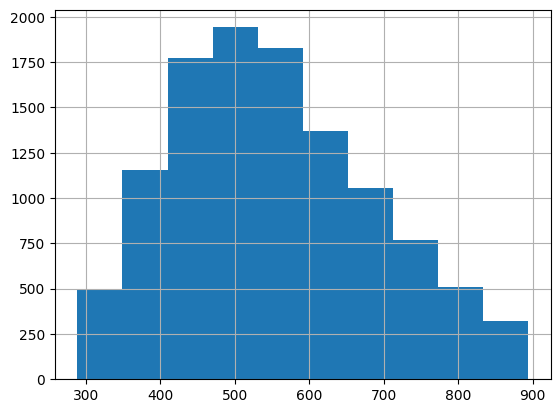

In [20]:
this[feat].hist()

In [21]:
this['vol_bins'] = pd.cut(this[feat], bins=5)
this['vol_bins_ind'] = pd.factorize(this['vol_bins'])[0]

# this['vol_bins'] = pd.qcut(this[feat], q=5)
# this['vol_bins_ind'] = pd.factorize(this['vol_bins'])[0]

In [24]:
this['vol_bins'].value_counts()

(409.944, 530.983]    3714
(530.983, 652.022]    3200
(652.022, 773.062]    1827
(288.3, 409.944]      1650
(773.062, 894.101]     831
Name: vol_bins, dtype: int64

In [22]:
this['vol_bins_ind'].value_counts()

1    3714
0    3200
3    1827
4    1650
2     831
Name: vol_bins_ind, dtype: int64

In [56]:
this['vol_bins_ind'].value_counts()

1    3714
0    3200
3    1827
4    1650
2     831
Name: vol_bins_ind, dtype: int64

In [23]:
this['vol_bins'].astype(str).iloc[0]

'(530.983, 652.022]'

In [58]:
all_features = this[[i for i in this.columns if "mu" in i]].values
this['vol_bins'] = this['vol_bins'].astype(str)
for hh in this['vol_bins'].unique():
    this_ret = this.loc[this['vol_bins'] == hh].reset_index(drop=True)
    
    this_mu = np.expand_dims(this_ret[[i for i in this_ret.columns if "mu" in i]].mean(axis=0), axis=0)
    dist = (all_features - this_mu) ** 2
    # dist = np.sum(dist, axis=1)
    k = 2
    # print(min(latent_dim, all_features.shape[0]))
    inds = np.argpartition(dist.sum(axis=-1), k)[:k] # get 10 closest
    closest_samples = this.iloc[inds].reset_index(drop=True)
    for ind, row in closest_samples.iterrows():
        # closest_real_id = this.iloc[closest_idx]['CellId']
        closest_real_id = row['CellId']
        print(closest_idx, this_ret['vol_bins'].unique(), all_features.shape, this_ret.shape, this_ret['NUC_shape_volume_lcc'].mean(), closest_real_id)
        mesh = pv.read(mesh_df.loc[mesh_df['CellId'] == closest_real_id]['mesh_path_noalign'].iloc[0])
        mesh.save(f'./npm1_global/vol_bin2/{hh}_{ind}_{closest_real_id}.ply')
        

4582 ['(421511.6, 517596.4]'] (11222, 512) (3200, 2120) 464810.43875 956566
4582 ['(421511.6, 517596.4]'] (11222, 512) (3200, 2120) 464810.43875 644268
4582 ['(325426.8, 421511.6]'] (11222, 512) (3714, 2120) 375122.11604738823 667253
4582 ['(325426.8, 421511.6]'] (11222, 512) (3714, 2120) 375122.11604738823 667385
4582 ['(613681.2, 709766.0]'] (11222, 512) (831, 2120) 654923.182912154 723148
4582 ['(613681.2, 709766.0]'] (11222, 512) (831, 2120) 654923.182912154 646422
4582 ['(517596.4, 613681.2]'] (11222, 512) (1827, 2120) 560717.0164203612 976080
4582 ['(517596.4, 613681.2]'] (11222, 512) (1827, 2120) 560717.0164203612 646422
4582 ['(228861.576, 325426.8]'] (11222, 512) (1650, 2120) 289799.6527272727 641993
4582 ['(228861.576, 325426.8]'] (11222, 512) (1650, 2120) 289799.6527272727 644268


In [225]:
dist.shape

(11222,)

In [81]:
this_mu.shape

(1, 512)

In [76]:
this

,Unnamed: 0,CellId,mu_0,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,...,str_skeleton_nodes_number,str_skeleton_voxels_number,str_symmetry_x,str_symmetry_y,str_symmetry_z,this_cell_nbr_dist_3d,this_cell_nbr_overlap_area,well_name,vol_bins,vol_bins_ind
0,0,657022,0.024874,0.030914,0.017546,0.016288,0.031083,0.010763,0.025891,0.021957,...,NaN,NaN,NaN,NaN,NaN,"[(657027, 171.18079307761494), (657028, 147.69...","[(657027, 12183), (657028, 46151), (657040, 11...",E7,"(389826.0, 469811.0]",0
1,1,674437,0.022291,0.046217,0.038931,0.019586,0.028120,0.020312,0.012554,0.033614,...,NaN,NaN,NaN,NaN,NaN,"[(674438, 73.48614210199406), (674443, 147.763...","[(674438, 149725), (674443, 72821), (674446, 7...",F4,"(469811.0, 549796.0]",1
2,2,680877,0.016793,0.046142,0.016380,0.032346,0.040916,0.021908,0.008750,0.014573,...,NaN,NaN,NaN,NaN,NaN,"[(680864, 97.21118030666638), (680867, 193.743...","[(680864, 75295), (680867, 25662)]",E6,"(389826.0, 469811.0]",0
3,3,644885,0.015497,0.030139,0.015893,0.018405,0.017438,0.019185,0.024507,0.026978,...,NaN,NaN,NaN,NaN,NaN,"[(644859, 134.16342528287066), (644867, 165.14...","[(644859, 115481), (644867, 100752), (644868, ...",E7,"(549796.0, 629781.0]",2
4,4,698458,0.019080,0.034809,0.019705,0.044710,0.030379,0.017513,0.004102,0.027020,...,NaN,NaN,NaN,NaN,NaN,"[(698467, 137.8824132131454), (698480, 170.911...","[(698467, 96853), (698480, 41439)]",E4,"(549796.0, 629781.0]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,11809,666297,0.029465,0.015416,0.033433,0.018233,0.031175,0.015625,0.036696,0.006959,...,NaN,NaN,NaN,NaN,NaN,"[(666296, 191.65978538970617), (666298, 184.20...","[(666296, 3994), (666298, 46948), (666302, 198...",E6,"(309441.075, 389826.0]",3
10037,11810,672827,0.020525,0.047327,0.016294,0.008579,0.052202,0.013861,0.012849,0.030450,...,NaN,NaN,NaN,NaN,NaN,"[(672818, 168.5850786193163), (672828, 155.509...","[(672818, 23433), (672828, 79747)]",F6,"(389826.0, 469811.0]",0
10038,11811,672150,0.027334,0.034170,0.022150,0.022869,0.023579,0.008439,0.019456,0.023942,...,NaN,NaN,NaN,NaN,NaN,"[(672140, 138.504078424156), (672148, 124.4938...","[(672140, 27089), (672148, 16062), (672149, 79...",F7,"(389826.0, 469811.0]",0
10039,11812,730047,0.022846,0.037411,0.027477,0.010640,0.025011,0.015189,0.035402,0.044410,...,NaN,NaN,NaN,NaN,NaN,"[(730040, 142.25046649579733), (730043, 211.46...","[(730040, 77719), (730043, 19113), (730045, 11...",E8,"(629781.0, 709766.0]",4
